# Data preprocessing

This notebook preprocesses MovieLens 32M and TMDB datasets to create three model-specific datasets:
1. **Collaborative Filtering**: User-item interaction matrix
2. **Content-Based Filtering**: Movie metadata with embeddings
3. **Two-Tower Model**: Combined ratings and movie features

## 1. Data Fetching

In [ ]:
# Login to kaggle
import kagglehub as kh
import os
os.environ['KAGGLEHUB_CACHE'] = './data'

In [2]:
# Downloading datasets
movie_path = kh.dataset_download("asaniczka/tmdb-movies-dataset-2023-930k-movies")
ratings_path = kh.dataset_download("justsahil/movielens-32m")

print(f"Movies path: {movie_path}")
print(f"Ratings path: {ratings_path}")

Movies path: /Users/bartek/Desktop/bachelors/model/data/datasets/asaniczka/tmdb-movies-dataset-2023-930k-movies/versions/743
Ratings path: /Users/bartek/Desktop/bachelors/model/data/datasets/justsahil/movielens-32m/versions/1


## 2. Load Data with Polars


In [3]:
import polars as pl
import numpy as np

movie_df = pl.read_csv(movie_path + '/TMDB_movie_dataset_v11.csv')
ratings_df = pl.read_csv(ratings_path + '/ml-32m/ratings.csv')
links_df = pl.read_csv(ratings_path + '/ml-32m/links.csv')

print(f"Movies: {movie_df.shape}")
print(f"Ratings: {ratings_df.shape}")
print(f"Links: {links_df.shape}")


Movies: (1314057, 24)
Ratings: (32000204, 4)
Links: (87585, 3)


## 3. Early Column Filtering


In [4]:
movie_df = movie_df.select([
    'id', 'title', 'overview', 'tagline', 'genres', 'keywords',
    'vote_average', 'vote_count', 'runtime', 'release_date', 'original_language'
])

print(f"Columns: {movie_df.columns}")


Columns: ['id', 'title', 'overview', 'tagline', 'genres', 'keywords', 'vote_average', 'vote_count', 'runtime', 'release_date', 'original_language']


## 4. Handle Invalid Ratings

Ratings < 0.5 indicate no rating (not an actual 0.5 rating)


In [5]:
invalid_count = ratings_df.filter(pl.col('rating') < 0.5).shape[0]
print(f"Invalid ratings: {invalid_count}")

ratings_df = ratings_df.with_columns(
    pl.when(pl.col('rating') < 0.5)
      .then(None)
      .otherwise(pl.col('rating'))
      .alias('rating')
)

print(f"Set to null: {invalid_count}")


Invalid ratings: 0
Set to null: 0


## 5. Merge Datasets


In [6]:
# Merge ratings with links
merged_df = ratings_df.join(links_df, on='movieId', how='inner')

# Merge with movie metadata
merged_df = merged_df.join(movie_df, left_on='tmdbId', right_on='id', how='inner')

In [7]:
merged_df

userId,movieId,rating,timestamp,imdbId,tmdbId,title,overview,tagline,genres,keywords,vote_average,vote_count,runtime,release_date,original_language
i64,i64,f64,i64,i64,i64,str,str,str,str,str,f64,i64,i64,str,str
1,17,4.0,944249077,114388,4584,"""Sense and Sensibility""","""The Dashwood sisters, sensible…","""Lose your heart and come to yo…","""Drama, Romance""","""secret love, london, england, …",7.443,1522,136,"""1995-12-13""","""en"""
1,25,1.0,944250228,113627,451,"""Leaving Las Vegas""","""Ben Sanderson, an alcoholic Ho…","""I Love You... The Way You Are.""","""Drama, Romance""","""hotel room, dying and death, i…",7.259,1278,111,"""1995-10-27""","""en"""
1,29,2.0,943230976,112682,902,"""The City of Lost Children""","""A scientist in a surrealist so…","""Where happily ever after is ju…","""Fantasy, Science Fiction, Adve…","""rescue, friendship, island, dr…",7.278,975,108,"""1995-05-17""","""fr"""
1,30,5.0,944249077,115012,37557,"""Shanghai Triad""","""Shanghai, China, 1930. When yo…","""In 1930, Shanghai violence was…","""Drama, Crime""","""shanghai, china, chinese mafia…",6.77,76,108,"""1995-09-14""","""zh"""
1,32,5.0,943228858,114746,63,"""Twelve Monkeys""","""In the year 2035, convict Jame…","""The future is history.""","""Science Fiction, Thriller, Mys…","""biological weapon, philadelphi…",7.6,7677,129,"""1995-12-29""","""en"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
200948,79702,4.5,1294412589,446029,22538,"""Scott Pilgrim vs. the World""","""As bass guitarist for a garage…","""Get the hot girl. Defeat her e…","""Action, Comedy, Romance""","""canada, video game, ex-boyfrie…",7.469,7155,113,"""2010-08-12""","""en"""
200948,79796,1.0,1287216292,1020558,23759,"""Centurion""","""Britain, A.D. 117. Quintus Dia…","""History is written in blood""","""Adventure, Action, Drama""","""roman empire, ancient rome, an…",6.193,1280,97,"""2010-02-15""","""en"""
200948,80350,0.5,1294412671,1666186,40264,"""Vampires Suck""","""Becca, an anxious, non-vampire…","""Some sagas just won't die.""","""Horror, Comedy""","""high school, vampire, parody, …",4.275,1169,82,"""2010-08-18""","""en"""


## 6. Data Cleaning


In [8]:
merged_df = merged_df.with_columns([
    pl.col('overview').fill_null(''),
    pl.col('tagline').fill_null(''),
    pl.col('genres').fill_null('[]'),
    pl.col('keywords').fill_null('[]'),
    pl.col('runtime').fill_null(pl.col('runtime').median()),
    pl.col('vote_average').fill_null(0),
    pl.col('vote_count').fill_null(0)
])

# Drop rows with missing id or title
initial_rows = merged_df.shape[0]
merged_df = merged_df.drop_nulls(subset=['movieId', 'title'])
print(f"Dropped {initial_rows - merged_df.shape[0]} rows")

Dropped 0 rows


## 7. Create Dataset 1: Collaborative Filtering


In [26]:
# Filter out null ratings and select only necessary columns
ratings_cf = merged_df.filter(pl.col('rating').is_not_null())
ratings_cf = ratings_cf.select(['userId', 'movieId', 'tmdbId', 'rating', 'timestamp'])

# Calculate sparsity
n_users = ratings_cf['userId'].n_unique()
n_movies = ratings_cf['tmdbId'].n_unique()
sparsity = 1 - (ratings_cf.shape[0] / (n_users * n_movies))
print(f"Matrix sparsity: {sparsity:.4%}")

Matrix sparsity: 99.8093%


In [25]:
ratings_cf.describe()

statistic,userId,movieId,tmdbId,rating,timestamp
str,f64,f64,f64,f64,f64
"""count""",3.1922307e7,3.1922307e7,3.1922307e7,3.1922307e7,3.1922307e7
"""null_count""",0.0,0.0,0.0,0.0,0.0
"""mean""",100278.397503,29110.915674,38395.744887,3.539802,1.2747e9
"""std""",57948.512075,50760.079022,101551.169961,1.058847,2.5613e8
"""min""",1.0,1.0,2.0,0.5,7.89652004e8
"""25%""",50053.0,1230.0,713.0,3.0,1.0501e9
"""50%""",100297.0,3439.0,8208.0,3.5,1.2714e9
"""75%""",150449.0,44191.0,14069.0,4.0,1.5026e9
"""max""",200948.0,292757.0,1.186337e6,5.0,1.6972e9


In [10]:
ratings_cf

userId,movieId,tmdbId,rating,timestamp
i64,i64,i64,f64,i64
1,17,4584,4.0,944249077
1,25,451,1.0,944250228
1,29,902,2.0,943230976
1,30,37557,5.0,944249077
1,32,63,5.0,943228858
…,…,…,…,…
200948,79702,22538,4.5,1294412589
200948,79796,23759,1.0,1287216292
200948,80350,40264,0.5,1294412671


## 8. Create Dataset 2: Content-Based Filtering

Process movie metadata and generate embeddings


In [11]:
# Get unique movies
movies_cb = movie_df.unique(subset=['id'])

print(f"Unique movies: {movies_cb.shape[0]:,}")
print(f"Columns: {movies_cb.columns}")


Unique movies: 1,312,963
Columns: ['id', 'title', 'overview', 'tagline', 'genres', 'keywords', 'vote_average', 'vote_count', 'runtime', 'release_date', 'original_language']


### Merging the feature columns

We want to merge the feature columns into one single column so that we have a one string to have embeddings from.
I've decided to merge `title`, `overview`, `tagline`, `genres`, `keywords` columns, since they will be the most important for content based filtering.

In [ ]:
import pandas as pd

# Convert to pandas
movies_cb_pd = movies_cb.to_pandas()
movies_cb_pd.head()

,id,title,overview,tagline,genres,keywords,vote_average,vote_count,runtime,release_date,original_language
0,1469949,An Australian Duck in Paris,A group of international students in Paris rec...,"Home is not a place, it is a memory, always fa...",Documentary,,10.0,1,3,2025-04-23,en
1,491833,Der Senator,,,Drama,,0.0,0,0,1968-12-06,de
2,1290764,异域狼孩,,,,,0.0,0,0,,zh
3,338848,The Rasmus: Live Letters,Live Letters is a live DVD by the Finnish rock...,,Music,"concert, music video, symphonic rock, alternat...",0.0,0,107,2004-11-22,en
4,1392090,Yaya,,,"Thriller, Drama",,0.0,0,0,2024-10-01,es


In [13]:
import re

# remove emojis
movies_cb_pd['overview'] = movies_cb_pd['overview'].apply(lambda x: re.sub(r'[^\x00-\x7F]+', '', x))
movies_cb_pd['tagline'] = movies_cb_pd['tagline'].apply(lambda x: re.sub(r'[^\x00-\x7F]+', '', x))

movies_cb_pd['merged_text'] = (
    movies_cb_pd['title'].fillna('') + ' ' +
    movies_cb_pd['overview'].fillna('') + ' ' +
    movies_cb_pd['tagline'].fillna('') + ' ' +
    movies_cb_pd['genres'].fillna('') + ' ' +
    movies_cb_pd['keywords'].fillna('')
).str.strip()

# Clean up extra spaces
movies_cb_pd['merged_text'] = movies_cb_pd['merged_text'].str.replace(r'\s+', ' ', regex=True)

print(f"Average text length: {movies_cb_pd['merged_text'].str.len().mean():.2f}")


Average text length: 250.80


In [14]:
movies_cb_pd.head()

,id,title,overview,tagline,genres,keywords,vote_average,vote_count,runtime,release_date,original_language,merged_text
0,1469949,An Australian Duck in Paris,A group of international students in Paris rec...,"Home is not a place, it is a memory, always fa...",Documentary,,10.0,1,3,2025-04-23,en,An Australian Duck in Paris A group of interna...
1,491833,Der Senator,,,Drama,,0.0,0,0,1968-12-06,de,Der Senator Drama
2,1290764,异域狼孩,,,,,0.0,0,0,,zh,异域狼孩
3,338848,The Rasmus: Live Letters,Live Letters is a live DVD by the Finnish rock...,,Music,"concert, music video, symphonic rock, alternat...",0.0,0,107,2004-11-22,en,The Rasmus: Live Letters Live Letters is a liv...
4,1392090,Yaya,,,"Thriller, Drama",,0.0,0,0,2024-10-01,es,"Yaya Thriller, Drama"


### Generate TF-IDF Embeddings


In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy.sparse as sp

tfidf_vectorizer = TfidfVectorizer(
    max_features=10000,
    stop_words='english',
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.8
)

tfidf_embeddings = tfidf_vectorizer.fit_transform(movies_cb_pd['merged_text'])

print(f"TF-IDF shape: {tfidf_embeddings.shape}")
print(f"Vocabulary size: {len(tfidf_vectorizer.vocabulary_)}")
print(f"Sparsity: {tfidf_embeddings.nnz / (tfidf_embeddings.shape[0] * tfidf_embeddings.shape[1]):.4%}")


TF-IDF shape: (1312963, 10000)
Vocabulary size: 10000
Sparsity: 0.1853%


### Generate BERT Embeddings


In [16]:
import torch

# Check if MPS is available for MacOS

if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


In [18]:
from sentence_transformers import SentenceTransformer

# Load model (huggingface)
bert_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

# Encode
bert_embeddings = bert_model.encode(
    movies_cb_pd['merged_text'].tolist(),
    batch_size=32,
    show_progress_bar=True,
    convert_to_numpy=True
)

print(f"BERT embeddings shape: {bert_embeddings.shape}")
print(f"Embedding dimension: {bert_embeddings.shape[1]}")


Batches:   0%|          | 0/41031 [00:00<?, ?it/s]

BERT embeddings shape: (1312963, 384)
Embedding dimension: 384


In [19]:
# Convert back to Polars with essential columns

movies_cb_final = movies_cb_pd[[
    'id', 'title', 'overview', 'tagline', 'genres', 
    'vote_average', 'vote_count', 'runtime', 'release_date', 
    'original_language', 'merged_text'
]]

# Convert back to Polars for efficient storage
movies_cb = pl.from_pandas(movies_cb_final)

print(f"Content-based dataset ready: {movies_cb.shape}")


Content-based dataset ready: (1312963, 11)


## 9. Create Dataset 3: Two-Tower Model Training Data


In [20]:
movies_cb

id,title,overview,tagline,genres,vote_average,vote_count,runtime,release_date,original_language,merged_text
i64,str,str,str,str,f64,i64,i64,str,str,str
1469949,"""An Australian Duck in Paris""","""A group of international stude…","""Home is not a place, it is a m…","""Documentary""",10.0,1,3,"""2025-04-23""","""en""","""An Australian Duck in Paris A …"
491833,"""Der Senator""","""""","""""","""Drama""",0.0,0,0,"""1968-12-06""","""de""","""Der Senator Drama"""
1290764,"""异域狼孩""","""""","""""","""""",0.0,0,0,"""""","""zh""","""异域狼孩"""
338848,"""The Rasmus: Live Letters""","""Live Letters is a live DVD by …","""""","""Music""",0.0,0,107,"""2004-11-22""","""en""","""The Rasmus: Live Letters Live …"
1392090,"""Yaya""","""""","""""","""Thriller, Drama""",0.0,0,0,"""2024-10-01""","""es""","""Yaya Thriller, Drama"""
…,…,…,…,…,…,…,…,…,…,…
1391670,"""Captain Obvious""","""Captain Obvious is trying to g…","""you can always count on""","""Crime, Comedy""",0.0,0,4,"""2023-09-11""","""en""","""Captain Obvious Captain Obviou…"
600337,"""Category X""","""On the set of Jack Tyler's ""Le…","""""","""""",0.0,0,63,"""2014-09-21""","""fr""","""Category X On the set of Jack …"
1201213,"""Alexandria""","""Books vanish from a library. A…","""""","""""",0.0,0,20,"""""","""en""","""Alexandria Books vanish from a…"


In [21]:
# Select movie features for item tower
movie_features = movies_cb.select([
    'id', 'merged_text', 'genres', 'vote_average', 'vote_count', 'runtime'
])

# Join with ratings
two_tower_df = ratings_cf.join(
    movie_features,
    left_on='tmdbId',
    right_on='id',
    how='inner'
)

print(f"Two-tower training samples: {two_tower_df.shape[0]:,}")
print(f"Unique users: {two_tower_df['userId'].n_unique():,}")
print(f"Unique movies: {two_tower_df['tmdbId'].n_unique():,}")
print(f"\nColumns: {two_tower_df.columns}")

Two-tower training samples: 31,922,307
Unique users: 200,948
Unique movies: 83,323

Columns: ['userId', 'movieId', 'tmdbId', 'rating', 'timestamp', 'merged_text', 'genres', 'vote_average', 'vote_count', 'runtime']


In [22]:
two_tower_df.head()

userId,movieId,tmdbId,rating,timestamp,merged_text,genres,vote_average,vote_count,runtime
i64,i64,i64,f64,i64,str,str,f64,i64,i64
1,17,4584,4.0,944249077,"""Sense and Sensibility The Dash…","""Drama, Romance""",7.443,1522,136
1,25,451,1.0,944250228,"""Leaving Las Vegas Ben Sanderso…","""Drama, Romance""",7.259,1278,111
1,29,902,2.0,943230976,"""The City of Lost Children A sc…","""Fantasy, Science Fiction, Adve…",7.278,975,108
1,30,37557,5.0,944249077,"""Shanghai Triad Shanghai, China…","""Drama, Crime""",6.77,76,108
1,32,63,5.0,943228858,"""Twelve Monkeys In the year 203…","""Science Fiction, Thriller, Mys…",7.6,7677,129


## 10. Data Validation & Statistics


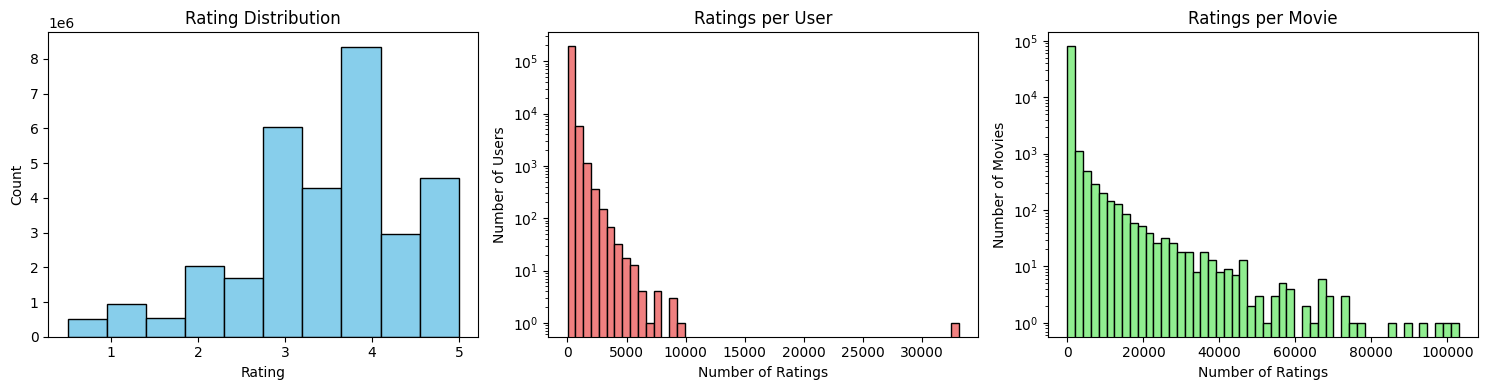


Ratings per user - Min: 15, Max: 33083, Median: 72
Ratings per movie - Min: 1, Max: 102929, Median: 5


In [23]:
import matplotlib.pyplot as plt

# Visualizations
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Convert to pandas for plotting
ratings_cf_pd = ratings_cf.to_pandas()

# Rating distribution
axes[0].hist(ratings_cf_pd['rating'], bins=10, edgecolor='black', color='skyblue')
axes[0].set_title('Rating Distribution')
axes[0].set_xlabel('Rating')
axes[0].set_ylabel('Count')

# Ratings per user
user_counts = ratings_cf_pd.groupby('userId').size()
axes[1].hist(user_counts, bins=50, edgecolor='black', color='lightcoral')
axes[1].set_title('Ratings per User')
axes[1].set_xlabel('Number of Ratings')
axes[1].set_ylabel('Number of Users')
axes[1].set_yscale('log')

# Ratings per movie
movie_counts = ratings_cf_pd.groupby('tmdbId').size()
axes[2].hist(movie_counts, bins=50, edgecolor='black', color='lightgreen')
axes[2].set_title('Ratings per Movie')
axes[2].set_xlabel('Number of Ratings')
axes[2].set_ylabel('Number of Movies')
axes[2].set_yscale('log')

plt.tight_layout()
plt.show()

print(f"\nRatings per user - Min: {user_counts.min()}, Max: {user_counts.max()}, Median: {user_counts.median():.0f}")
print(f"Ratings per movie - Min: {movie_counts.min()}, Max: {movie_counts.max()}, Median: {movie_counts.median():.0f}")


## 11. Save Processed Datasets


In [24]:
import joblib
import json

output_dir = 'data/processed'
os.makedirs(output_dir, exist_ok=True)

# 1. Collaborative Filtering
ratings_cf.write_parquet(f'{output_dir}/ratings_cf.parquet')

# 2. Content-Based Filtering
movies_cb.write_parquet(f'{output_dir}/movies_cb.parquet')
np.save(f'{output_dir}/bert_embeddings_cb.npy', bert_embeddings)
sp.save_npz(f'{output_dir}/tfidf_embeddings_cb.npz', tfidf_embeddings)
joblib.dump(tfidf_vectorizer, f'{output_dir}/tfidf_vectorizer.pkl')

# 3. Two-Tower Model
two_tower_df.write_parquet(f'{output_dir}/two_tower_train.parquet')

# 4. Metadata
metadata = {
    'collaborative_filtering': {
        'num_ratings': int(ratings_cf.shape[0]),
        'num_users': int(ratings_cf['userId'].n_unique()),
        'num_movies': int(ratings_cf['tmdbId'].n_unique()),
        'avg_rating': float(ratings_cf['rating'].mean()),
        'sparsity': float(sparsity)
    },
    'content_based': {
        'num_movies': int(movies_cb.shape[0]),
        'tfidf_dim': tfidf_embeddings.shape[1],
        'bert_dim': bert_embeddings.shape[1],
        'bert_model': 'sentence-transformers/all-MiniLM-L6-v2'
    },
    'two_tower': {
        'num_samples': int(two_tower_df.shape[0]),
        'num_users': int(two_tower_df['userId'].n_unique()),
        'num_movies': int(two_tower_df['tmdbId'].n_unique())
    }
}

with open(f'{output_dir}/metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)

with open(f'metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)
    